In [21]:

import numpy 
import os, glob
import tifffile
import torch
import random
import pickle

from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from skimage import measure, feature
from scipy.spatial import distance
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter

from wavelet import detect_spots

import sys
from stedfm.model_builder import get_pretrained_model_v2
from stedfm.utils import savefig
sys.path.insert(0, '..')
from stats import resampling_stats

PIXELSIZE = 0.015 # in um

# block_to_0mg_cmap = LinearSegmentedColormap.from_list('blockto0mg', ['grey', 'dodgerblue'], N=256, gamma=1.0)
block_to_0mg_cmap = LinearSegmentedColormap.from_list('blockto0mg', ['grey', 'darkseagreen'], N=256, gamma=1.0)
colormaps.register(block_to_0mg_cmap, force=True)
colormaps.register(block_to_0mg_cmap.reversed(), force=True)

# block_to_0mg_cmap = LinearSegmentedColormap.from_list('blocktoglugly', ['grey', 'limegreen'], N=256, gamma=1.0)
block_to_0mg_cmap = LinearSegmentedColormap.from_list('blocktoglugly', ['grey', 'peru'], N=256, gamma=1.0)
colormaps.register(block_to_0mg_cmap, force=True)
colormaps.register(block_to_0mg_cmap.reversed(), force=True)

COLORMAPS = {
    "0Mg" : LinearSegmentedColormap.from_list('0mg', ['white', 'darkseagreen'], N=256, gamma=1.0),
    "Block" : LinearSegmentedColormap.from_list('block', ['white', 'grey'], N=256, gamma=1.0),
    "GluGly" : LinearSegmentedColormap.from_list('block', ['white', 'peru'], N=256, gamma=1.0),
}

/tmp/ipykernel_193381/578043164.py:30: UserWarning: Overwriting the cmap 'blockto0mg' that was already in the registry.
  colormaps.register(block_to_0mg_cmap, force=True)
/tmp/ipykernel_193381/578043164.py:31: UserWarning: Overwriting the cmap 'blockto0mg_r' that was already in the registry.
  colormaps.register(block_to_0mg_cmap.reversed(), force=True)
/tmp/ipykernel_193381/578043164.py:35: UserWarning: Overwriting the cmap 'blocktoglugly' that was already in the registry.
  colormaps.register(block_to_0mg_cmap, force=True)
/tmp/ipykernel_193381/578043164.py:36: UserWarning: Overwriting the cmap 'blocktoglugly_r' that was already in the registry.
  colormaps.register(block_to_0mg_cmap.reversed(), force=True)


In [22]:
latent_encoder, model_config = get_pretrained_model_v2(
    name="mae-lightning-small",
    weights="MAE_SMALL_STED",
    path=None,
    mask_ratio=0.0,
    pretrained=False,
    in_channels=1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)
if torch.cuda.is_available():
    latent_encoder = latent_encoder.cuda()

mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local2/projects/SSL/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- ViT case with none-ImageNet weights or from scratch ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


In [53]:
def get_cmap(condition, N=None):
    if N is None:
        N = 256
    if condition == "Block-0Mg":
        cmap = pyplot.get_cmap("blockto0mg", N)
    elif condition == "0Mg-Block":
        cmap = pyplot.get_cmap("blockto0mg_r", N)
    elif condition == "Block-GluGly":
        cmap = pyplot.get_cmap("blocktoglugly", N)
    return cmap

def load_files(path, exclude=None, include=None):
    files = glob.glob(path)
    files.sort()
    if exclude is not None:
        files = [f for f in files if not any([f"_{e}_" in f for e in exclude])]
    if include is not None:
        files = [f for f in files if any([f"_{i}_" in f for i in include])]
    return files

def extract_features(file, show=False):
    image = tifffile.imread(file)

    filtered_image = gaussian_filter(image, sigma=1.0)

    # mask = detect_spots(image, J_list=[2, 3], scale_threshold=5.0)
    mask = detect_spots(image, J_list=[3, 4], scale_threshold=2.0)

    # foreground = numpy.count_nonzero(mask)
    # pixels = image.shape[0] * image.shape[1]
    # ratio = foreground / pixels 
    # if ratio < 0.05:
    #     return None

    if show:    
        fig, axes = pyplot.subplots(1, 2)
        axes[0].imshow(image, cmap='gray')
        axes[1].imshow(mask, cmap='gray')
        pyplot.show()

    mask_label, num_proteins = measure.label(mask, return_num=True)
    props = measure.regionprops(mask_label, intensity_image=image)
    coordinates = numpy.array([p.weighted_centroid for p in props])

    distances = distance.pdist(coordinates) * PIXELSIZE
    distances = distance.squareform(distances)

    nn_distances = numpy.sort(distances, axis=1)[:, 1]

    image_density = num_proteins / (image.shape[0] * image.shape[1] * PIXELSIZE**2)
    density_proteins = (numpy.sum(distances < 0.5, axis=1) - 1) / 1 # in number of proteins per um^2

    features = []
    counter = 0
    for prop, density, nn in zip(props, density_proteins, nn_distances):

        # img = prop.intensity_image
        slc = prop.slice
        img = filtered_image[slc]
        label = prop.image

        min_distance = int(0.08 / PIXELSIZE) // 2 + 1 # in pixels
        peaks = feature.peak_local_max(img, min_distance=min_distance, exclude_border=False, labels=label)

        if show:
            fig, axes = pyplot.subplots(1, 2)
            axes[0].imshow(img, cmap='gray')
            axes[0].plot(peaks[:, 1], peaks[:, 0], 'r.')
            axes[1].imshow(label, cmap='gray')
            pyplot.show()

        features.append([
            prop.area,
            prop.perimeter,
            prop.mean_intensity,
            prop.eccentricity,
            prop.solidity,
            density,
            nn,
            len(peaks)
        ])

        # counter += 1
        # if counter > 5:
        #     break

    return numpy.array(features)

def extract_deep_features(file, show=False):
    image = tifffile.imread(file)
    
    X = torch.tensor(image).unsqueeze(0).unsqueeze(0).float()
    if torch.cuda.is_available():
        X = X.cuda()
    with torch.no_grad():
        latent = latent_encoder.forward_features(X)
        latent = latent.cpu().numpy().flatten()
    return latent
    
def gen_trajectory(files, per_protein=False, extract_deep=False):
    trajectories = defaultdict(list)
    for file in files:
        name = os.path.basename(file).split('.')[0].split("_")[-3]
        trajectories[name].append(file)
    for name, files in tqdm(trajectories.items(), desc="Loading trajectories"):

        files = list(sorted(files, key=lambda x: int(os.path.basename(x).split('.')[0].split("_")[-1])))

        timesteps, features, deep_features = [], [], []
        counter = 0
        for file in files:
            
            if extract_deep:
                deep_feature = extract_deep_features(file)
                deep_features.append(deep_feature)

            feature_per_image = extract_features(file, show=False)
            if feature_per_image is None:
                continue
            avg_feature = numpy.mean(feature_per_image, axis=0)
            std_feature = numpy.std(feature_per_image, axis=0)

            if per_protein:
                timesteps.extend([int(os.path.basename(file).split('.')[0].split("_")[-1])] * len(feature_per_image))
                features.extend(feature_per_image)
            else:
                timesteps.append(int(os.path.basename(file).split('.')[0].split("_")[-1]))
                # features.append(
                #     numpy.concatenate([avg_feature, std_feature])
                # )
                features.append(
                    avg_feature
                )

        yield name, numpy.array(deep_features), numpy.array(features), numpy.array(timesteps)

        # counter += 1
        # if counter > 5:
        #     break        

files = {
    "Block-0Mg" : load_files('./activity-experiment/examples/raw-tif/*0Mg*.tif'), #exclude=["2", "4", "7", "9", "11", "15", "17", "22", "28", "32", "40", "41", "44", "50", "52", "54"]),
    # "0Mg-Block" : load_files('./activity-experiment/examples/raw-tif/*Block*.tif'),
    "Block-GluGly" : load_files('./activity-block-glugly-experiment/examples/raw-tif/*GluGly*.tif', exclude=["5", "6", "9", "14", "15", "16", "17", "20", "26", "33", "44", "49", "54", "55", "56", "59", "62", "63", "66", "69", "70", "71", "72"]),
    # "GluGly-Block" : load_files('./activity-block-glugly-experiment/examples/raw-tif/*Block*.tif'),
}
FEATURES = ["Area", "Perimeter", "Mean Intensity", "Eccentricity", "Solidity", "Density", "NN", "Peaks"]
for key, values in files.items():
    print(key, len(values))

Block-0Mg 258
Block-GluGly 324


# Per protein

In [54]:
trajectory_id_per_condition, timesteps_per_condition, deep_trajectories_per_condition, trajectories_per_condition = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
for condition, files_per_condition in files.items():
    for name, deep_features, features, steps in gen_trajectory(files_per_condition, per_protein=True):
        trajectory_id_per_condition[condition].extend([name] * len(steps))
        timesteps_per_condition[condition].extend(steps)
        trajectories_per_condition[condition].append(features)

Loading trajectories:   0%|          | 0/43 [00:00<?, ?it/s]

Loading trajectories:   0%|          | 0/54 [00:00<?, ?it/s]

288
457
83
43


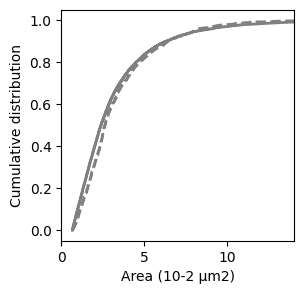

288
457
83
43


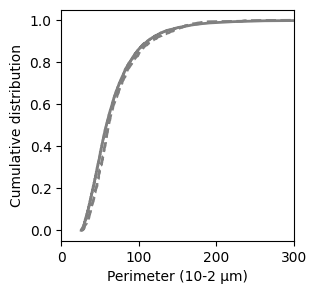

288
457
83
43


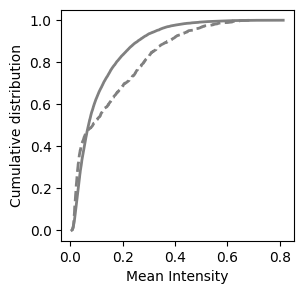

288
457
83
43


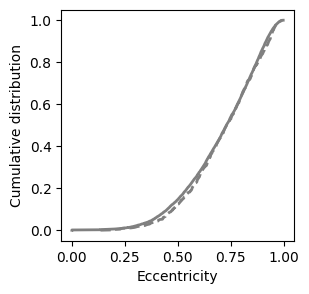

288
457
83
43


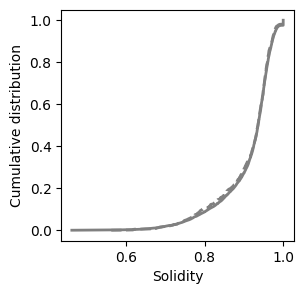

288
457
83
43


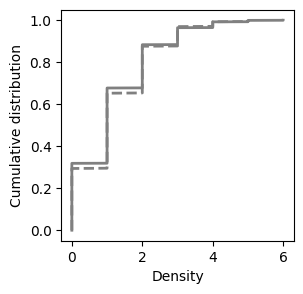

288
457
83
43


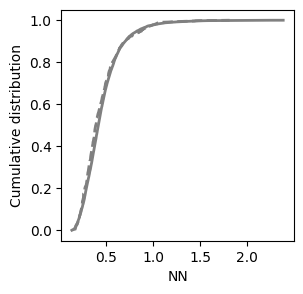

288
457
83
43


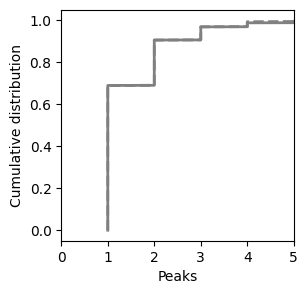

457
134
77
97


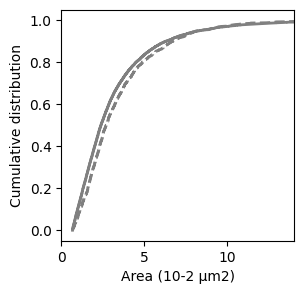

457
134
77
97


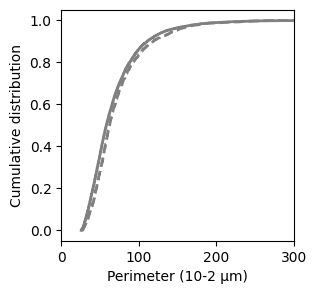

457
134
77
97


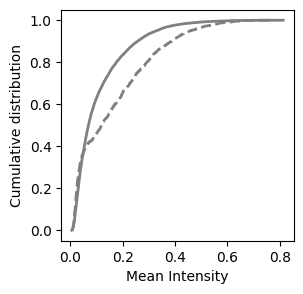

457
134
77
97


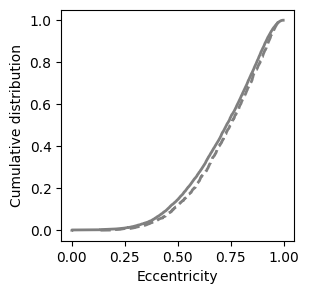

457
134
77
97


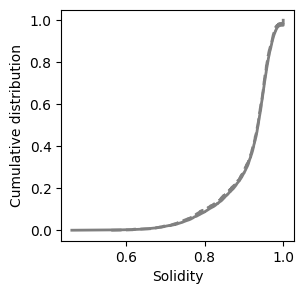

457
134
77
97


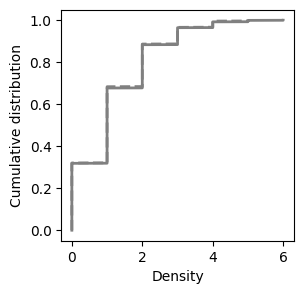

457
134
77
97


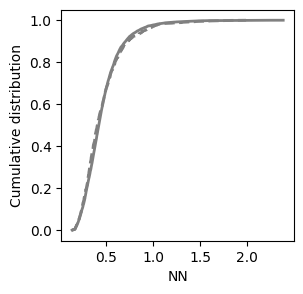

457
134
77
97


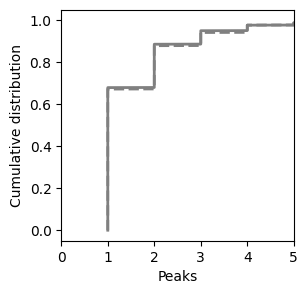

Block-0Mg
288
457
Block-0Mg (4681, 8) (4681,)


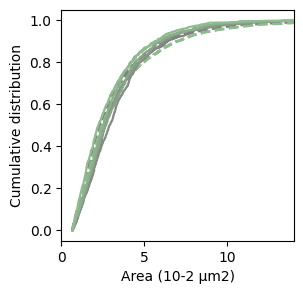

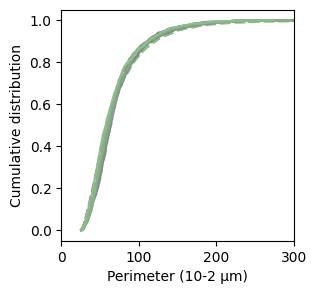

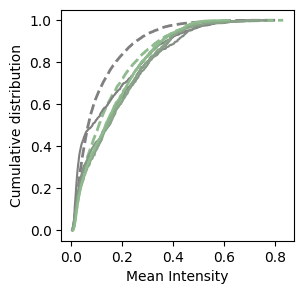

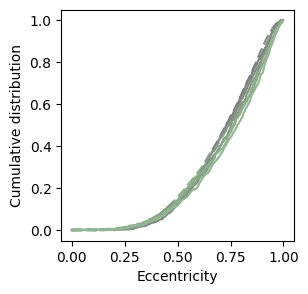

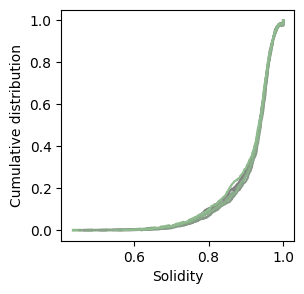

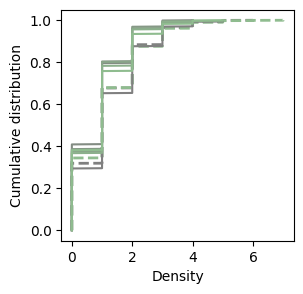

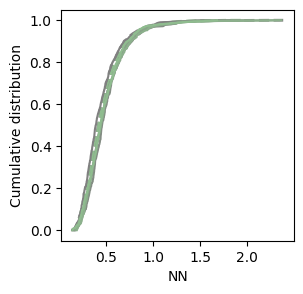

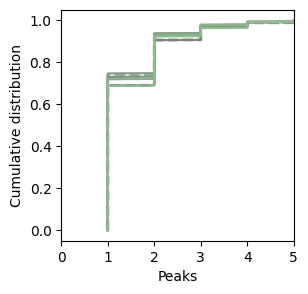

Block-GluGly
457
134
Block-GluGly (8427, 8) (8427,)


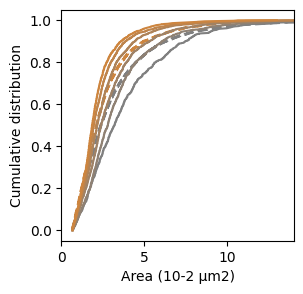

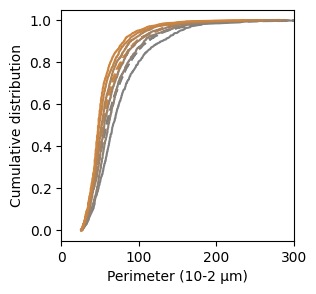

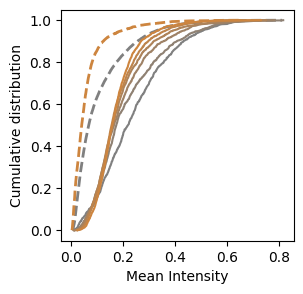

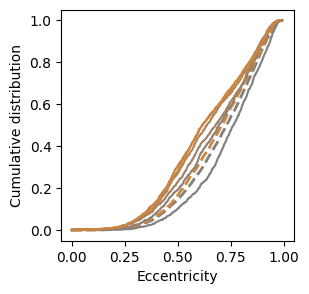

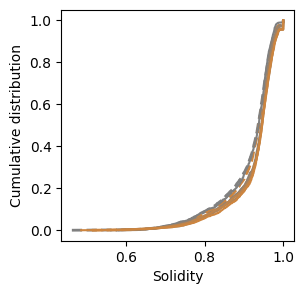

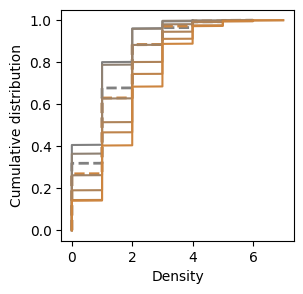

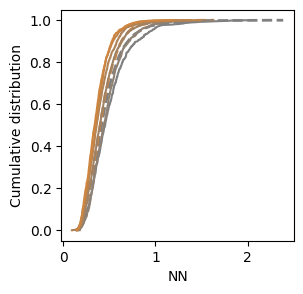

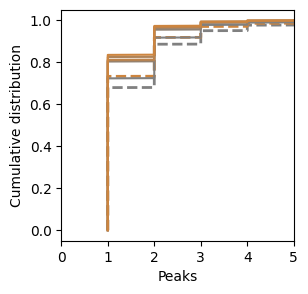

In [56]:
def load_ground_truth_data(condition, split="train"):
    if condition == "Block-GluGly":
        with open(f"./activity-block-glugly-experiment/features/real-images-features-{split}.pkl", "rb") as f:
            data = pickle.load(f)
    elif condition == "Block-0Mg":
        with open(f"./activity-experiment/features/real-images-features-{split}.pkl", "rb") as f:
            data = pickle.load(f)
    
    for key, values in data.items():
        print(len(values))
        values = numpy.concatenate(values, axis=0)
        data[key] = values

    if "0MgGlyBic" in data:
        data["0Mg"] = data["0MgGlyBic"]
        del data["0MgGlyBic"]
    
    return data    

def map_features(feat, values):
    if feat == "Area":
        values = values * (PIXELSIZE ** 2) * 1e+2
    elif feat == "Perimeter":
        values = values * PIXELSIZE * 1e+2  
    return values

for condition, trajectories in trajectories_per_condition.items():
    timesteps = numpy.array(timesteps_per_condition[condition])
    cmap = get_cmap(condition, N=len(numpy.unique(timesteps)))
    for i, feat in enumerate(FEATURES):
        
        fig, ax = pyplot.subplots(figsize=(3, 3))

        gt_data = load_ground_truth_data(condition, split="train")

        # Ground truth data
        srckey, dstkey = condition.split("-")
        src = gt_data[srckey]
        dst = gt_data[dstkey]
        if i < src.shape[-1]:
            src = map_features(feat, src[:, i])
            dst = map_features(feat, dst[:, i])
        
            ax.plot(numpy.sort(src), numpy.linspace(0, 1, len(src)), color=cmap(0.0), linewidth=2, linestyle="solid")
            # ax.plot(numpy.sort(dst), numpy.linspace(0, 1, len(dst)), color=cmap(1.0), linewidth=2, linestyle="solid")

        gt_data = load_ground_truth_data(condition, split="test")

        # Ground truth data
        srckey, dstkey = condition.split("-")
        src = gt_data[srckey]
        dst = gt_data[dstkey]
        if i < src.shape[-1]:
            src = map_features(feat, src[:, i])
            dst = map_features(feat, dst[:, i])
        
            ax.plot(numpy.sort(src), numpy.linspace(0, 1, len(src)), color=cmap(0.0), linewidth=2, linestyle="dashed")
            # ax.plot(numpy.sort(dst), numpy.linspace(0, 1, len(dst)), color=cmap(1.0), linewidth=2, linestyle="dashed")            

        if feat == "Area":
            feat = feat + " (10-2 µm2)"
            ax.set(xlim=(0, 14))
        elif feat == "Perimeter":
            feat = feat + " (10-2 µm)"  
            ax.set(xlim=(0, 300))
        elif feat == "Peaks":
            ax.set(xlim=(0, 5))
        ax.set(
            xlabel=feat,
            ylabel="Cumulative distribution",
        )
        pyplot.show()

for condition, trajectories in trajectories_per_condition.items():

    print(condition)
    gt_data = load_ground_truth_data(condition, split="train")

    trajectories = numpy.concatenate(trajectories, axis=0)
    timesteps = numpy.array(timesteps_per_condition[condition])

    print(condition, trajectories.shape, timesteps.shape)
    
    for i, feat in enumerate(FEATURES):
        fig, ax = pyplot.subplots(figsize=(3, 3))
        cmap = get_cmap(condition, N=len(numpy.unique(timesteps)))

        # Ground truth data
        srckey, dstkey = condition.split("-")
        src = gt_data[srckey]
        dst = gt_data[dstkey]
        if i < src.shape[-1]:
            src = map_features(feat, src[:, i])
            dst = map_features(feat, dst[:, i])
        
            ax.plot(numpy.sort(src), numpy.linspace(0, 1, len(src)), color=cmap(0.0), linewidth=2, linestyle="dashed")
            ax.plot(numpy.sort(dst), numpy.linspace(0, 1, len(dst)), color=cmap(1.0), linewidth=2, linestyle="dashed")

        for t in numpy.unique(timesteps):
            mask = timesteps == t
            traj = map_features(feat, numpy.sort(trajectories[mask, i]))
            ax.plot(traj, numpy.linspace(0, 1, len(traj)), color=cmap(t), alpha=1.0)
        feat_ = feat
        if feat == "Area":
            feat_ = feat + " (10-2 µm2)"
            ax.set(xlim=(0, 14))
        elif feat == "Perimeter":
            feat_ = feat + " (10-2 µm)"  
            ax.set(xlim=(0, 300))
        elif feat == "Peaks":
            ax.set(xlim=(0, 5))
        ax.set(
            xlabel=feat_,
            ylabel="Cumulative distribution",
        )
        savefig(fig, f"./activity-block-glugly-experiment/panels/cumulative-distribution/{condition}-{feat}", save_white=True)
        pyplot.show()


# Per image

In [57]:
trajectory_id_per_condition, timesteps_per_condition, deep_trajectories_per_condition, trajectories_per_condition = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
for condition, files_per_condition in files.items():
    for name, deep_features, features, steps in gen_trajectory(files_per_condition, per_protein=False, extract_deep=True):
        trajectory_id_per_condition[condition].extend([name] * len(steps))
        timesteps_per_condition[condition].extend(steps)
        trajectories_per_condition[condition].append(features)
        deep_trajectories_per_condition[condition].append(deep_features)


Loading trajectories:   0%|          | 0/43 [00:00<?, ?it/s]

Loading trajectories:   0%|          | 0/54 [00:00<?, ?it/s]

In [58]:
import pickle
data = {
    "trajectories" : trajectories_per_condition,
    "deep_trajectories" : deep_trajectories_per_condition,
    "timesteps" : timesteps_per_condition,
    "trajectory_id" : trajectory_id_per_condition,
}
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

Block-0Mg


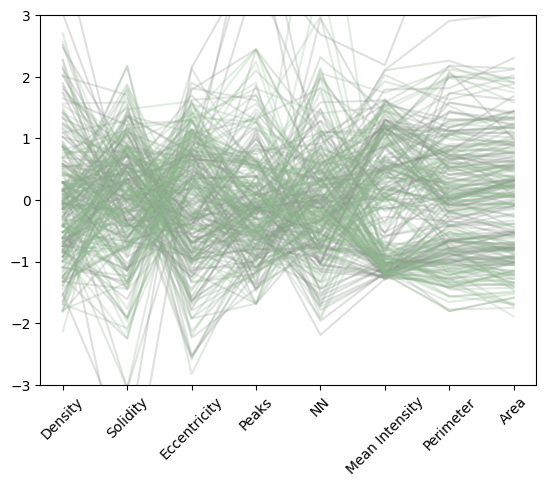

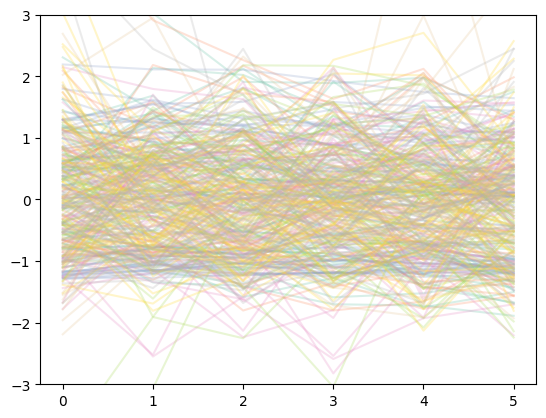

Block-GluGly


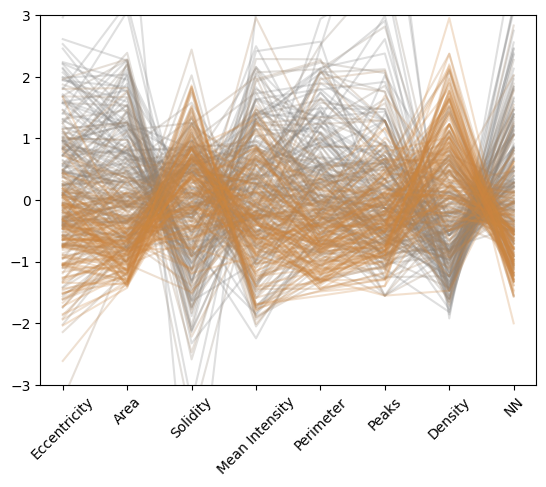

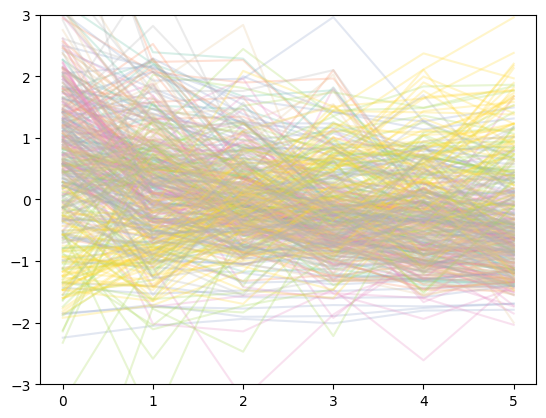

In [59]:
for condition in files.keys():
    print(condition)
    if len(trajectories_per_condition[condition]) == 0:
        continue

    trajectories = numpy.array(trajectories_per_condition[condition])
    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])

    # Normalize the data
    for i in range(trajectories.shape[2]):
        mean = numpy.mean(trajectories[:, :, i])
        std = numpy.std(trajectories[:, :, i])
        trajectories[:, :, i] = (trajectories[:, :, i] - mean) / std

    variances = numpy.var(trajectories, axis=(0, 1))
    sorted_idx = numpy.argsort(variances)[::-1]
    fig, ax = pyplot.subplots()
    cmap = get_cmap(condition, trajectories.shape[1])
    for t in range(trajectories.shape[1]):
        for trajectory in trajectories[:, t]:
            ax.plot(trajectory[sorted_idx], color=cmap(t), alpha=0.25)
    ax.set(
        ylim=(-3, 3),
    )
    ax.set_xticks(
        numpy.arange(0, len(sorted_idx), 1), labels=[FEATURES[i] for i in sorted_idx],
        rotation=45
    )
    pyplot.show()

    # Plots the features as a function of time
    fig, ax = pyplot.subplots()
    cmap = pyplot.get_cmap("Set2", trajectories.shape[-1])
    for t in range(trajectories.shape[-1]):
        for trajectory in trajectories[:, :, t]:
            ax.plot(trajectory, color=cmap(t), alpha=0.25)
    ax.set(
        ylim=(-3, 3),
    )
    ax.set_xticks(
        numpy.arange(0, trajectories.shape[1], 1),
    )
    pyplot.show()    


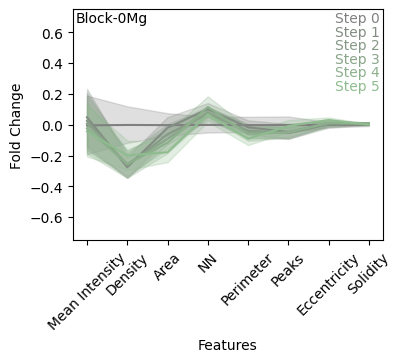

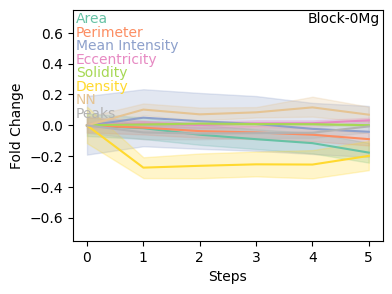

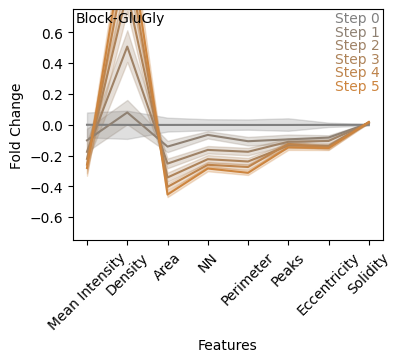

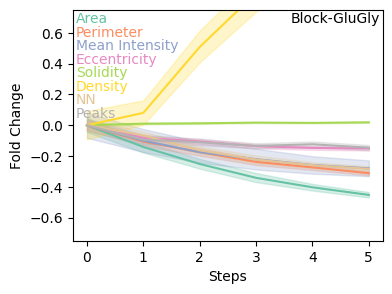

In [60]:
class FoldChangeScaler:
    def __init__(self, trajectory_id, index=0):
        self.index = index

        self.baseline = None

    def fit_transform(self, X, trajectory_id=None):
        if trajectory_id is None:
            baselines = X[:, [self.index]]
            self.baseline = numpy.mean(baselines, axis=0, keepdims=True)

            return (X - baselines) / baselines

        X = X.copy()
        baselines = []
        for trajectory in set(trajectory_id):
            mask = trajectory_id == trajectory
            baseline = X[mask][[self.index], :]
            baselines.append(baseline)
        baseline = numpy.mean(baselines, axis=0)
        # X = numpy.log2(X + 1) - numpy.log2(baseline + 1)
        X = (X - baseline) / baseline
        # X[mask] = (X[mask] - baseline) / baseline
        return X

# Generate bootstrap trajectories
def bootstrap(samples, n=1000):
    out = []
    for _ in range(n):
        items = numpy.random.choice(samples, len(samples))
        bootstrap_sample = []
        for item in items:
            mask = trajectory_id == item
            bootstrap_sample.append(trajectories[mask])
        mean = numpy.mean(bootstrap_sample, axis=0)

        out.append(mean)
    out = numpy.array(out)
    return out

def get_confidence_interval(bootstrapped_trajectory, indices, axis=0):
    mean, cid, ciu = numpy.percentile(numpy.take(bootstrapped_trajectory, indices, axis=axis), [50, 5.0, 95], axis=0) 
    return mean, cid, ciu   

def from_categorical(names):
    unique_names = list(sorted(set(names)))
    return numpy.array([unique_names.index(name) for name in names])

def convert_timesteps(timesteps, invert=False):
    unique_timesteps = list(sorted(set(timesteps)))
    return numpy.array([
        max(unique_timesteps) - unique_timesteps.index(t) if invert else unique_timesteps.index(t) for t in timesteps])

def get_mask_real_images(timesteps):
    return numpy.array([t == 0 for t in timesteps])

random.seed(42)
numpy.random.seed(42)

scaled_trajectories_per_condition = {}

standard_scaler = StandardScaler()
all_trajectories = numpy.concatenate([
    trajectories_per_condition["Block-0Mg"], 
    # trajectories_per_condition["Block"],
    trajectories_per_condition["Block-GluGly"]
], axis=0)
standard_scaler.fit(all_trajectories.reshape(-1, all_trajectories.shape[-1]))

for condition in ["Block-0Mg", "Block-GluGly"]:

    n = 10000
    trajectories = numpy.array(trajectories_per_condition[condition])
    trajectory_id = numpy.array(trajectory_id_per_condition[condition])

    trajectories_ = trajectories.copy()

    # Fold change scaling to plot the data
    scaler = FoldChangeScaler(trajectory_id, index=0)
    trajectories = scaler.fit_transform(trajectories.reshape(-1, trajectories.shape[-1]), trajectory_id=trajectory_id)

    # Standardization of the data for each feature
    # scaler = StandardScaler()
    # trajectories = scaler.fit_transform(trajectories_.reshape(-1, trajectories_.shape[-1]))
    scaled_trajectories_per_condition[condition] = standard_scaler.transform(trajectories_.reshape(-1, trajectories_.shape[-1]))

    bootstrapped_trajectory = bootstrap(list(set(trajectory_id)), n)

    variances = numpy.var(bootstrapped_trajectory, axis=(0, 1))
    if condition == "Block-0Mg":
        sorted_idx = numpy.argsort(variances)[::-1]
    # sorted_idx = numpy.arange(0, len(sorted_idx), 1)

    fig, ax = pyplot.subplots(figsize=(4, 3))
    cmap = get_cmap(condition, bootstrapped_trajectory.shape[1])
    for t in range(bootstrapped_trajectory.shape[1]):
        mean, cid, ciu = get_confidence_interval(bootstrapped_trajectory, t, axis=1)
        # for trajectory in bootstrapped_trajectory[:, t]:
            # ax.plot(trajectory[sorted_idx], color=cmap(t), alpha=0.1)
        ax.plot(mean[sorted_idx], color=cmap(t))
        ax.fill_between(
            numpy.arange(0, bootstrapped_trajectory.shape[-1], 1),
            cid[sorted_idx], ciu[sorted_idx], color=cmap(t), alpha=0.25
        )
        ax.annotate(
            f'Step {t}',
            xy=(0.99, 1 - 0.35 * (t + 1)/bootstrapped_trajectory.shape[1]), color=cmap(t),
            xycoords='axes fraction',
            horizontalalignment='right'
        )
    ax.set(
        ylim=(-0.75, 0.75), ylabel="Fold Change", xlabel="Features"
    )
    ax.set_xticks(
        numpy.arange(0, len(sorted_idx), 1), labels=[FEATURES[i] for i in sorted_idx],
        rotation=45
    )
    ax.annotate(
        condition,
        xy=(0.01, 0.99),
        xycoords='axes fraction',
        horizontalalignment='left',
        verticalalignment='top'
    )    
    savefig(fig, "./activity-experiment/figures/manual-features/{}_trajectory-per-feature".format(condition), save_white=True)
    pyplot.show()


    fig, ax = pyplot.subplots(figsize=(4, 3))
    cmap = pyplot.get_cmap("Set2", bootstrapped_trajectory.shape[-1])
    for t in range(bootstrapped_trajectory.shape[-1]):
        mean, cid, ciu = get_confidence_interval(bootstrapped_trajectory, t, axis=2)
        ax.plot(mean, color=cmap(t))
        ax.fill_between(
            numpy.arange(0, bootstrapped_trajectory.shape[1], 1),
            cid, ciu, color=cmap(t), alpha=0.25
        )
        # for trajectory in bootstrapped_trajectory[:, :, t]:
        #     ax.plot(trajectory, color=cmap(t), alpha=0.1)
        ax.annotate(
            FEATURES[t],
            xy=(0.01, 1 - 0.35 * (t + 1)/bootstrapped_trajectory.shape[1]), color=cmap(t),
            xycoords='axes fraction',
            horizontalalignment='left'
        )
    ax.annotate(
        condition,
        xy=(0.99, 0.99),
        xycoords='axes fraction',
        horizontalalignment='right',
        verticalalignment='top'
    )
    ax.set(
        ylim=(-0.75, 0.75), ylabel="Fold Change", xlabel="Steps"
    )
    # ax.set_xticks(
    #     numpy.arange(0, len(sorted_idx), 1), labels=[FEATURES[i] for i in sorted_idx],
    #     rotation=45
    # ) 
    savefig(fig, "./activity-experiment/figures/manual-features/{}_trajectory-per-steps".format(condition), save_white=True)
    pyplot.show()

    bootstrapped_trajectory_id = numpy.array([[f'bootstrap_{i}' for _ in range(bootstrapped_trajectory.shape[-1])] for i in range(len(bootstrapped_trajectory))]).ravel()
    bootstrapped_timesteps = numpy.array([[i for i in range(bootstrapped_trajectory.shape[-1])] for _ in range(len(bootstrapped_trajectory))]).ravel()
    bootstrapped_trajectory = bootstrapped_trajectory.reshape(-1, bootstrapped_trajectory.shape[-1])

    # mask = bootstrapped_timesteps != 0
    # bootstrapped_timesteps = bootstrapped_timesteps[mask]
    # bootstrapped_trajectory = bootstrapped_trajectory[mask]
    # bootstrapped_trajectory_id = bootstrapped_trajectory_id[mask]

    # print(bootstrapped_trajectory.shape)


In [61]:
import phate
from sklearn.decomposition import PCA

# block_mask = get_mask_real_images(convert_timesteps(timesteps_per_condition["Block"]))

timesteps = numpy.concatenate([
    convert_timesteps(timesteps_per_condition["Block-0Mg"]), 
    convert_timesteps(timesteps_per_condition["Block-GluGly"])
])
mask_real_image_per_condition = {
    "Block-0Mg": get_mask_real_images(convert_timesteps(timesteps_per_condition["Block-0Mg"])),
    # "Block": get_mask_real_images(convert_timesteps(timesteps_per_condition["Block"])),
    "Block-GluGly": get_mask_real_images(convert_timesteps(timesteps_per_condition["Block-GluGly"]))
}
mask_real_images = numpy.concatenate([
    get_mask_real_images(convert_timesteps(timesteps_per_condition["Block-0Mg"])),
    # get_mask_real_images(convert_timesteps(timesteps_per_condition["Block"]))[block_mask],
    get_mask_real_images(convert_timesteps(timesteps_per_condition["Block-GluGly"]))
])
trajectories = numpy.concatenate([
    scaled_trajectories_per_condition["Block-0Mg"], 
    # scaled_trajectories_per_condition["Block"][block_mask],
    scaled_trajectories_per_condition["Block-GluGly"],
])

phate_operator = phate.PHATE()
# embeded = phate_operator.fit_transform(bootstrapped_trajectory)
embeded = phate_operator.fit_transform(trajectories)
# embeded = phate_operator.fit_transform(deep_trajectories)

embeded_per_condition = {
    "Block-0Mg": embeded[:len(timesteps_per_condition["Block-0Mg"])],
    # "Block": embeded[len(timesteps_per_condition["0Mg"]): len(timesteps_per_condition["0Mg"]) + sum(block_mask)],
    "Block-GluGly": embeded[len(timesteps_per_condition["Block-0Mg"]):],
}

# pca = PCA(n_components=2)
# embeded = pca.fit_transform(trajectories)


Calculating PHATE...
  Running PHATE on 582 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 0.06 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.08 seconds.
  Calculating metric MDS...


/opt/anaconda3/envs/ssl/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 28 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated metric MDS in 0.15 seconds.
Calculated PHATE in 0.30 seconds.


# Real images analysis

In [29]:

def flatten(trajectories):
    out = []
    for traj in trajectories:
        out.extend(traj)
    return numpy.array(out)

for condition_a, condition_b in [("Block-0Mg", "0Mg-Block"), ("Block-GluGly", "GluGly-Block")]:

    traj_a = flatten(trajectories_per_condition[condition_a])
    traj_b = flatten(trajectories_per_condition[condition_b])

    traj_a = numpy.array(traj_a).reshape(-1, traj_a.shape[-1])
    traj_b = numpy.array(traj_b).reshape(-1, traj_b.shape[-1])

    mask_a = get_mask_real_images(convert_timesteps(timesteps_per_condition[condition_a]))
    mask_b = get_mask_real_images(convert_timesteps(timesteps_per_condition[condition_b]))

    print(traj_a.shape, traj_b.shape, mask_a.shape, mask_b.shape)
    traj_a = traj_a[mask_a]
    traj_b = traj_b[mask_b]

    fig, ax = pyplot.subplots()
    for i in range(len(FEATURES)):

        m, M = min(numpy.min(traj_a[:, i]), numpy.min(traj_b[:, i])), max(numpy.max(traj_a[:, i]), numpy.max(traj_b[:, i]))

        ax.boxplot([(traj_a[:, i] - m) / (M - m), (traj_b[:, i] - m) / (M - m)], positions=[i, i+0.45], widths=0.45)

        # p_value, F_p_value = resampling_stats([traj_a[:, i], traj_b[:, i]], [condition_a, condition_b])
        # print(FEATURES[i], p_value, F_p_value)
    ax.set_xticks(numpy.arange(0, len(FEATURES), 1) + 0.45/2, labels=FEATURES)
    ax.set_xticklabels(FEATURES, rotation=45)
    pyplot.show()

    for i in range(len(FEATURES)):
        fig, ax = pyplot.subplots()
        
        m, M = min(numpy.min(traj_a[:, i]), numpy.min(traj_b[:, i])), max(numpy.max(traj_a[:, i]), numpy.max(traj_b[:, i]))        
        a = (traj_a[:, i] - m) / (M - m)
        b = (traj_b[:, i] - m) / (M - m)

        sorted_a = numpy.sort(a)
        sorted_b = numpy.sort(b)

        ax.plot(sorted_a, numpy.linspace(0, 1, len(sorted_a)), label=condition_a.split("-")[0])
        ax.plot(sorted_b, numpy.linspace(0, 1, len(sorted_b)), label=condition_b.split("-")[0])
        ax.legend()
        ax.set_title(FEATURES[i])
        pyplot.show()

ValueError: cannot reshape array of size 0 into shape (0)

# Trajectory embedding

ValueError: 'c' argument has 80000 elements, which is inconsistent with 'x' and 'y' with size 516.

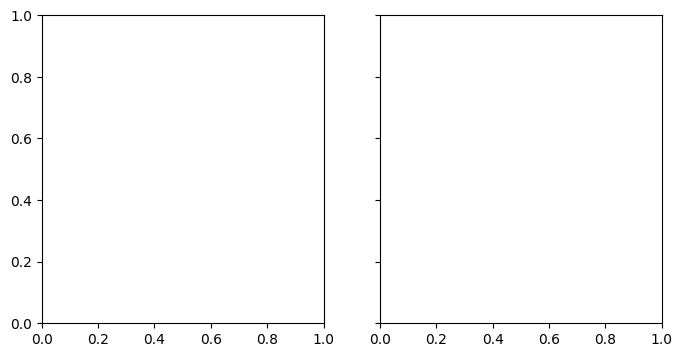

In [44]:
fig, axes = pyplot.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
axes[0].scatter(embeded[:, 0], embeded[:, 1], c=from_categorical(bootstrapped_trajectory_id), cmap='tab20')
axes[1].scatter(embeded[:, 0], embeded[:, 1], c=from_categorical(bootstrapped_timesteps), cmap="blockto0mg", alpha=0.25)
xlim, ylim = axes[0].get_xlim(), axes[0].get_ylim()
pyplot.show()

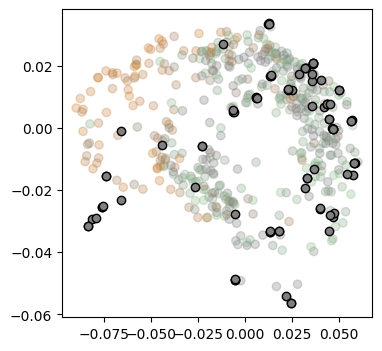

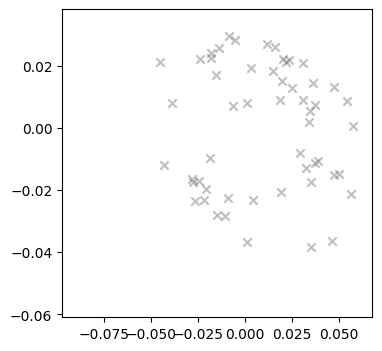

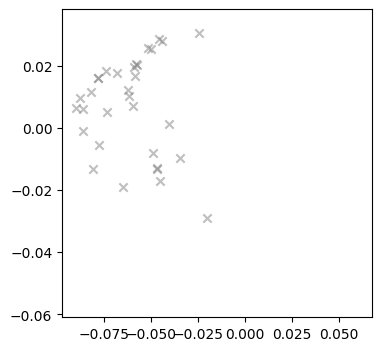

In [45]:
fig, ax = pyplot.subplots(figsize=(4, 4))
for condition in ["Block-0Mg", "Block-GluGly"]:

    mask_real_images_ = mask_real_image_per_condition[condition]
    timesteps_ = numpy.array(timesteps_per_condition[condition])
    embeded_ = embeded_per_condition[condition]
    if condition == "Block":
        timesteps_ = timesteps_[block_mask]

    ax.scatter(embeded_[~mask_real_images_, 0], embeded_[~mask_real_images_, 1], c=from_categorical(timesteps_)[~mask_real_images_], cmap=get_cmap(condition), alpha=0.3)
    ax.scatter(embeded_[mask_real_images_, 0], embeded_[mask_real_images_, 1], color=get_cmap(condition,2)(0), edgecolors='black', zorder=10)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
pyplot.show()

vectors_per_condition = {}

for condition in ["Block-0Mg", "Block-GluGly"]:
    fig, ax = pyplot.subplots(1, 1, figsize=(4, 4))
    vectors = []
    trajectory_id = trajectory_id_per_condition[condition]
    embeded_ = embeded_per_condition[condition]
    for name in set(trajectory_id):
        mask = numpy.array(trajectory_id) == name
        start = numpy.where(mask)[0][0]
        end = numpy.where(mask)[0][-1]
        # ax.scatter(embeded_[start, 0], embeded_[start, 1], c='gray', alpha=0.5)
        ax.scatter(embeded_[end, 0], embeded_[end, 1], c='gray', alpha=0.5, marker='x')
        # ax.plot([
        #     embeded_[start, 0],
        #     embeded_[end, 0]
        # ], [
        #     embeded_[start, 1],
        #     embeded_[end, 1]
        # ], c='gray', alpha=0.5)

        for idx in range(0, mask.sum() - 1):
            start = numpy.where(mask)[0][idx]
            end = numpy.where(mask)[0][-1]
            vectors.append({"start" : embeded_[start, :], "end" : embeded_[end, :]})
        # vectors.append({"start" : embeded_[start, :], "end" : embeded_[end, :]})
        # ax.plot(embeded_[mask, 0], embeded_[mask, 1], alpha=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    pyplot.show()

    vectors_per_condition[condition] = vectors



In [ ]:
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

num_points = 25
XX, YY = numpy.meshgrid(numpy.linspace(xlim[0], xlim[1], num_points), numpy.linspace(ylim[0], ylim[1], num_points))
delta_x = (xlim[1] - xlim[0]) / num_points
delta_y = (ylim[1] - ylim[0]) / num_points

def get_vectors_in_grid(vectors, x, y):
    valid_vectors = []
    for vector in vectors:
        start, end = vector["start"], vector["end"]

        distance = numpy.linalg.norm(end - start)
        
        fx, fy = interp1d([0, distance], [start[0], end[0]]), interp1d([0, distance], [start[1], end[1]])
        alpha = numpy.linspace(0, distance, 5)
        x_points, y_points = fx(alpha), fy(alpha)

        for x_point, y_point in zip(x_points, y_points):
            if x_point > x and x_point < x + delta_x and y_point > y and y_point < y + delta_y:
                valid_vectors.append(vector)
                break

        # if (start[0] > x and start[0] < x + delta_x and start[1] > y and start[1] < y + delta_y) or \
        #    (end[0] > x and end[0] < x + delta_x and end[1] > y and end[1] < y + delta_y):
        #     valid_vectors.append(vector)
    return valid_vectors

for condition in ["Block-0Mg", "Block-GluGly"]:
    other_condition = condition.split("-")[0]
    vectors = vectors_per_condition[condition]

    fig, ax = pyplot.subplots(1, 1, figsize=(4, 4))

    # dset = numpy.array([vector["end"] for vector in vectors]).T
    dset = embeded_per_condition[condition][mask_real_image_per_condition[condition]].T
    kernel = gaussian_kde(dset)

    ZZ = numpy.reshape(kernel(numpy.vstack([XX.ravel(), YY.ravel()])), XX.shape)
    ax.contour(XX, YY, ZZ, cmap=COLORMAPS[condition.split("-")[0]], linestyles="solid", )

    # for vector in vectors:
    #     ax.plot([vector["start"][0], vector["end"][0]], [vector["start"][1], vector["end"][1]], c='gray', alpha=0.5)
    #     # ax.scatter(vector["start"][0], vector["start"][1], c='gray', alpha=0.5)
    #     ax.scatter(vector["end"][0], vector["end"][1], c='gray', alpha=0.5, marker="x")
    max_norm = numpy.quantile([numpy.linalg.norm(vector["end"] - vector["start"]) for vector in vectors], 0.95)
    for x, y in zip(XX.ravel(), YY.ravel()):
        vectors_in_grid = get_vectors_in_grid(vectors, x, y)

        if len(vectors_in_grid) > 0:
            avg_direction = numpy.mean([vector["end"] - vector["start"] for vector in vectors_in_grid], axis=0)
            avg_direction = avg_direction #/ numpy.linalg.norm(avg_direction)
            avg_direction = avg_direction * 1.0
            norm = numpy.linalg.norm(avg_direction)
            ax.quiver(x + delta_x / 2, y + delta_y / 2, avg_direction[0], avg_direction[1], color='black', scale=1)#, alpha=min(1, (norm)/max_norm))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set(
        xlabel="PHATE 1", xticklabels=[],
        ylabel="PHATE 2", yticklabels=[],
    )
    # ax.set_title(f"{other_condition} to {condition}")
    savefig(fig, f"./activity-experiment/figures/manual-features/{other_condition}_to_{condition}_vector-field", save_white=True)
    pyplot.show()

# Deep features

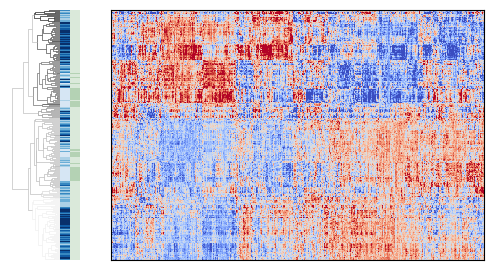

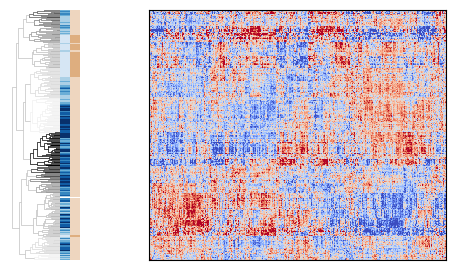

In [62]:
from scipy.cluster import hierarchy

SCALE = 0.5

for condition in ["Block-0Mg", "Block-GluGly"]:

    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])
    deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

    unique_names = list(sorted(set(trajectory_id_per_condition[condition])))
    trajectory_id = numpy.array([unique_names.index(name) for name in trajectory_id_per_condition[condition]])

    unique_names = list(sorted(set(timesteps_per_condition[condition])))
    timesteps = numpy.array([unique_names.index(name) for name in timesteps_per_condition[condition]])

    real_image = mask_real_image_per_condition[condition]
    
    D = deep_trajectories
    D = StandardScaler().fit_transform(D)

    Y = hierarchy.linkage(D, method="average", metric="cosine")
    Y2 = hierarchy.linkage(D.T, method="average", metric="cosine")
    # ind = hierarchy.fcluster(Y, dendrogram_distance, 'distance')  

    fig = pyplot.figure(figsize=(5, 5))

    ax3 = fig.add_axes([0,0,0.1,SCALE])
    ax3.set_xticks([])
    ax3.set_yticks([])
    fig.gca().invert_yaxis() # this plus the y-axis invert in the heatmap flips the y-axis heatmap orientation
    ax3.axis('off')    

    Z1 = hierarchy.dendrogram(
        Y, orientation='left',
        color_threshold=0.75, 
        above_threshold_color="silver",
        ax=ax3
    )    
    Z2 = hierarchy.dendrogram(
        Y2, orientation='left',
        color_threshold=0.75, 
        above_threshold_color="silver",
        no_plot=True
    )        
    for collection in ax3.collections:
        collection.set_linewidth(0.5)

    ax4 = fig.add_axes([0.1,0,0.02,SCALE])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.axis('off')
    cmap = pyplot.get_cmap("Blues", len(set(timesteps)) + 1)
    for i, leaf in enumerate(Z1["leaves"]):
        ax4.barh(i + 0.5, 1, 1.0, color=cmap(timesteps[leaf] + 1))
    #     # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
    ax4.set(
        ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
    )
    ax4.invert_yaxis()

    ax5 = fig.add_axes([0.12,0,0.02,SCALE])
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax5.axis('off')
    cmap = pyplot.get_cmap(COLORMAPS[condition.split("-")[1]], len(set(real_image)) + 1)
    cmap = COLORMAPS[condition.split("-")[1]]
    for i, leaf in enumerate(Z1["leaves"]):
        ax5.barh(i + 0.5, 1, 1.0, color=cmap((real_image[leaf] + 1) / (len(set(real_image)) + 1)))
        # ax4.axhline(i + 0.5, color=cmap(GROUPS_ROUTINE[groups[leaf]] + 1))
    ax5.set(
        ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
    )
    ax5.invert_yaxis()        

    axmatrix2 = fig.add_axes([0.15,0,0.85, SCALE])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']

    sorted_co_matrix = D[idx1,:]
    sorted_co_matrix = sorted_co_matrix[:,idx2]
    im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="coolwarm", vmin=-2, vmax=2)
    axmatrix2.set_xticks([])
    axmatrix2.set_yticks([])
    # fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis

    # num_cluster = ind.max().item()    

    # break

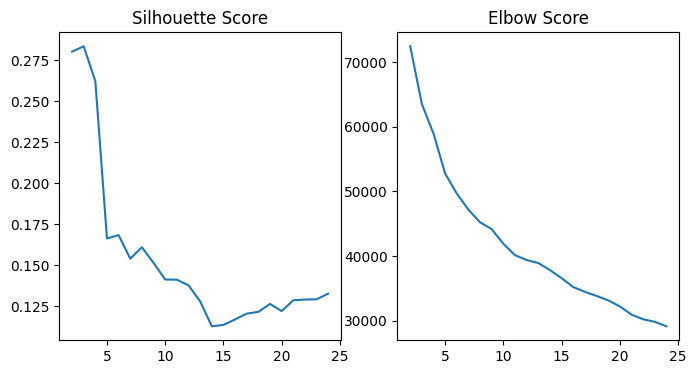

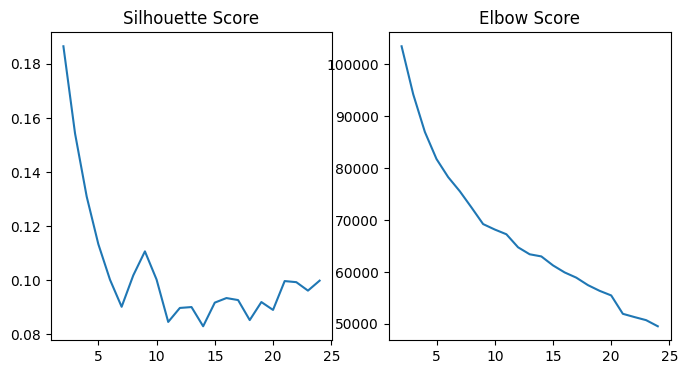

In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

matrices = {}
all_silhouettes = []
all_elbows = []

all_timesteps = []
all_trajectories = []
for condition in ["Block-0Mg", "Block-GluGly"]:

    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])
    deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

    mask = mask_real_image_per_condition[condition]
    deep_trajectories_real = deep_trajectories[mask]

    scaler = StandardScaler()
    scaler.fit(deep_trajectories)

    deep_trajectories = scaler.transform(deep_trajectories)

    unique_names = list(sorted(set(trajectory_id_per_condition[condition])))
    trajectory_id = numpy.array([unique_names.index(name) for name in trajectory_id_per_condition[condition]])

    unique_names = list(sorted(set(timesteps_per_condition[condition])))
    timesteps = numpy.array([unique_names.index(name) for name in timesteps_per_condition[condition]])
    
    all_timesteps.extend(timesteps)
    all_trajectories.extend(deep_trajectories)

    # deep_trajectories = numpy.array(all_trajectories)
    # timesteps = numpy.array(all_timesteps)

    n_clusters = 25
    #     n_clusters = min(50, n_clusters)
    cluster_matrix = numpy.zeros((len(deep_trajectories), len(deep_trajectories)))
    silhouettes = []
    elbows = []
    for n in range(2, n_clusters):
        kmeans = KMeans(n_clusters=n, random_state=42, n_init="auto").fit(deep_trajectories)

        klabels = kmeans.labels_
        for j in range(len(deep_trajectories)):
            for i in range(j, len(deep_trajectories)):
    #                 if j == i:
    #                     continue                    
                if klabels[j] == klabels[i]:
                    cluster_matrix[j, i] += 1
                    cluster_matrix[i, j] += 1   
                    
        silhouettes.append(silhouette_score(deep_trajectories, klabels, metric="euclidean"))
        elbows.append(kmeans.inertia_)
    matrices[condition] = cluster_matrix / n_clusters
    all_silhouettes.append(silhouettes)
    all_elbows.append(elbows)

for silhouette, elbow in zip(all_silhouettes, all_elbows):
    fig, axes = pyplot.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(numpy.arange(2, 2 + len(silhouette)), silhouette)
    axes[0].set_title("Silhouette Score")

    axes[1].plot(numpy.arange(2, 2 + len(elbow)), elbow)
    axes[1].set_title("Elbow Score")

    pyplot.show()    

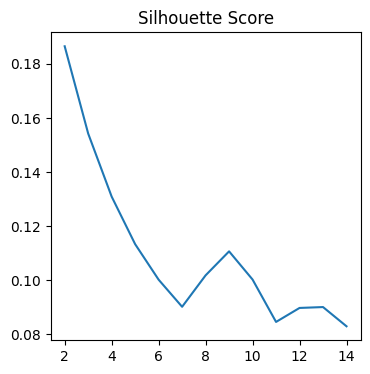

[0, 1, 2, 3, 4, 5]
5.874146746549666
[0, 1, 2, 3, 4, 5] [1 2 3]


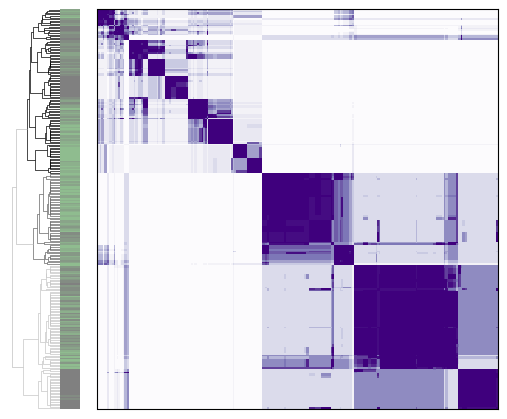

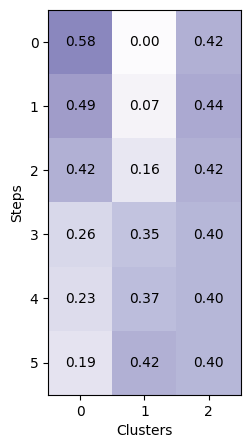

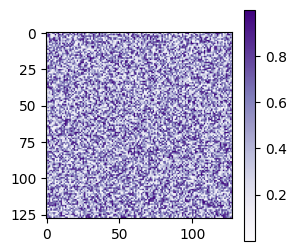

[0, 1, 2, 3, 4, 5]
5.406958479589051
[0, 1, 2, 3, 4, 5] [1 2 3]


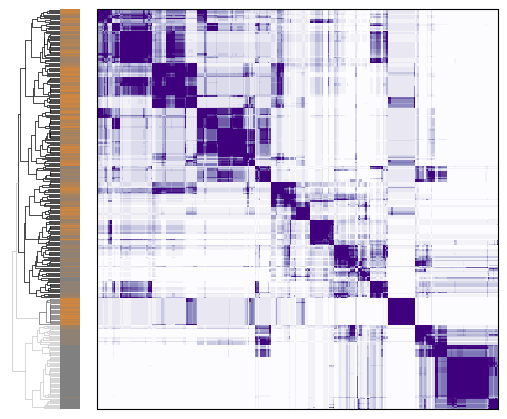

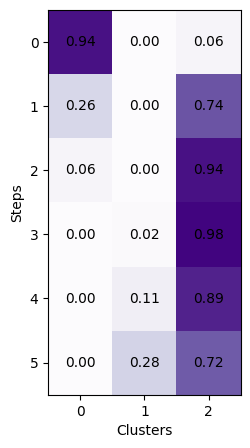

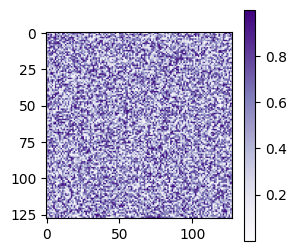

In [81]:
import matplotlib
from scipy.spatial import distance
from sklearn.cluster import KMeans

CLUSTERS = {
    "0Mg" : 10,
    "Block" : 8
}
SCALE = 0.8

deep_trajectories_real_images = []
# for condition in ["Block-0Mg", "Block-GluGly"]:
for condition in ["Block-GluGly"]:    
    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])
    deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

    # mask = mask_real_image_per_condition[condition]
    deep_trajectories_real_images.append(deep_trajectories)
    
deep_trajectories_real_images = numpy.concatenate(deep_trajectories_real_images)

scaler = StandardScaler()
deep_trajectories_real_images = scaler.fit_transform(deep_trajectories_real_images)

silhouettes = []
n_clusters = 15
for n in range(2, n_clusters):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init="auto").fit(deep_trajectories_real_images)
    klabels = kmeans.labels_
    silhouettes.append(silhouette_score(deep_trajectories_real_images, klabels, metric="euclidean"))

fig, ax = pyplot.subplots(1, 1, figsize=(4, 4))
ax.plot(numpy.arange(2, 2 + len(silhouettes)), silhouettes)
ax.set_title("Silhouette Score")
pyplot.show()

kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto").fit(deep_trajectories_real_images)

clusters_per_condition = {}

for condition in ["Block-0Mg", "Block-GluGly"]:

    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])
    deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

    # scaler = StandardScaler()
    # deep_trajectories = scaler.fit_transform(deep_trajectories)
    deep_trajectories = scaler.transform(deep_trajectories)

    unique_names = list(sorted(set(timesteps_per_condition[condition])))
    # unique_names = numpy.unique(timesteps)
    print(unique_names)
    timesteps = numpy.array([unique_names.index(name) for name in timesteps_per_condition[condition]])
    timesteps = convert_timesteps(timesteps, invert=condition == "Block")

    # fig, ax = pyplot.subplots(1, 1, figsize=(4, 4))
    # im = ax.matshow(correlation_matrix, cmap="magma", vmin=0, vmax=1)
    # pyplot.show()

    D = matrices[condition]

    distances = distance.cdist(D, D)
    mask = numpy.triu(numpy.ones_like(distances, dtype=bool)) * numpy.invert(numpy.eye(len(distances), dtype=bool))
    dendrogram_distance = numpy.quantile(distances[mask], q=0.5)  
    print(dendrogram_distance)  

    Y = hierarchy.linkage(D, method="average", metric="euclidean")
    Y2 = hierarchy.linkage(D.T, method="average", metric="euclidean")

    # labels = hierarchy.fcluster(Y, CLUSTERS[condition], 'maxclust')
    labels = hierarchy.fcluster(Y, dendrogram_distance, 'distance')
    clusters_per_condition[condition] = labels

    # dendrogram_distance = sorted(Y[:, 2])[-1 * CLUSTERS[condition] + 1]

    fig = pyplot.figure(figsize=(5, 5))

    ax3 = fig.add_axes([0,0,0.1,SCALE])
    ax3.set_xticks([])
    ax3.set_yticks([])
    fig.gca().invert_yaxis() # this plus the y-axis invert in the heatmap flips the y-axis heatmap orientation
    ax3.axis('off')    

    cmap = pyplot.get_cmap("Grays", (labels.max()).item()+1)
    hierarchy.set_link_color_palette([matplotlib.colors.to_hex(cmap(i+1)) for i in range(labels.max())])
    Z1 = hierarchy.dendrogram(
        Y, orientation='left',
        color_threshold=dendrogram_distance, 
        above_threshold_color="silver",
        ax=ax3
    )    
    Z2 = hierarchy.dendrogram(
        Y2, orientation='left',
        color_threshold=dendrogram_distance, 
        above_threshold_color="silver",
        no_plot=True
    )        
    for collection in ax3.collections:
        collection.set_linewidth(0.5)

    ax4 = fig.add_axes([0.1,0,0.04,SCALE])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.axis('off')
    # cmap = pyplot.get_cmap("Blues", len(set(timesteps)) + 1)
    cmap = get_cmap(condition, len(set(timesteps)))
    for i, leaf in enumerate(Z1["leaves"]):
        ax4.barh(i + 0.5, 1, 1.0, color=cmap(timesteps[leaf]))
        # ax4.axhline(i + 0.5, color=cmap(GROUPS_MODEL[groups[leaf]] + 1))
    ax4.set(
        ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
    )
    # ax4.invert_yaxis()

    # ax5 = fig.add_axes([0.12,0,0.02,1.0])
    # ax5.set_xticks([])
    # ax5.set_yticks([])
    # ax5.axis('off')
    # cmap = pyplot.get_cmap("Purples", len(set(trajectory_id)) + 1)
    # for i, leaf in enumerate(Z1["leaves"]):
    #     ax5.barh(i + 0.5, 1, 1.0, color=cmap(trajectory_id[leaf] + 1))
    #     # ax4.axhline(i + 0.5, color=cmap(GROUPS_ROUTINE[groups[leaf]] + 1))
    # ax5.set(
    #     ylim=(0, len(Z1["leaves"])), xlim=(0, 1)
    # )
    # ax5.invert_yaxis()        

    axmatrix2 = fig.add_axes([0.15,0,0.85, SCALE])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']

    sorted_co_matrix = D[idx1,:]
    sorted_co_matrix = sorted_co_matrix[:,idx2]
    im2 = axmatrix2.matshow(sorted_co_matrix, aspect='equal', origin='lower', cmap="Purples", vmin=0, vmax=0.5)
    axmatrix2.set_xticks([])
    axmatrix2.set_yticks([])
    # fig.gca().invert_yaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis
    fig.gca().invert_xaxis() # this plus the x-axis invert in the right-flipped dendrogram flips the y-axis

    savefig(fig, f"./activity-experiment/figures/deep-features/{condition}_dendrogram", save_white=True)

    #  num_cluster = ind.max().item()    
    uniques = numpy.unique(labels)

    # if condition == "0Mg":
    #     kmeans = KMeans(n_clusters=CLUSTERS[condition], random_state=42, n_init="auto").fit(deep_trajectories)
    #     labels = kmeans.labels_
    # else:
    # labels = kmeans.predict(deep_trajectories)
    # uniques = numpy.arange(0, kmeans.n_clusters)

    print(unique_names, uniques)
    proportions = numpy.zeros((len(unique_names), len(uniques)))
    for i, unique in enumerate(uniques):
        mask = labels == unique
        
        timestep, counts = numpy.unique(timesteps[mask], return_counts=True)
        for t, c in zip(timestep, counts):
            proportions[t, i] = c
    
    proportions = proportions / numpy.sum(proportions, axis=1, keepdims=True)


    fig, ax = pyplot.subplots(figsize=(10, 5))
    ax.imshow(proportions, vmin=0, vmax=1.0, cmap="Purples")
    for j in range(proportions.shape[1]):
        for i in range(proportions.shape[0]):
            ax.text(j, i, f'{proportions[i, j]:.2f}', ha='center', va='center', color='black')
    ax.set(
        xlabel="Clusters", ylabel="Steps"
    )
    savefig(fig, f"./activity-experiment/figures/deep-features/{condition}_proportion-per-steps", save_white=True)

    fig, ax = pyplot.subplots(figsize=(3, 3))
    im = ax.imshow(numpy.random.rand(128, 128), cmap="Purples")
    cbar = fig.colorbar(im, ax=ax)
    savefig(fig, f"./activity-experiment/figures/deep-features/{condition}_colorbar", save_white=True)
    pyplot.show()


(3, 324)


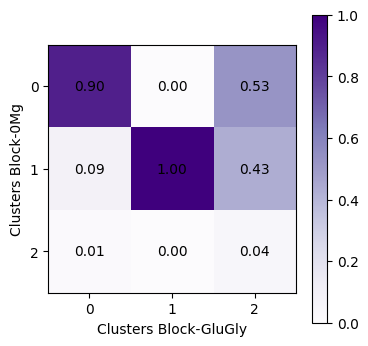

In [82]:
# Similarity between clusters
from scipy.spatial import distance
from itertools import combinations

all_deep_trajectories = []
for condition in ["Block-0Mg", "Block-GluGly"]:
    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])
    deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

    all_deep_trajectories.extend(deep_trajectories)

all_deep_trajectories = numpy.array(all_deep_trajectories)
scaler = StandardScaler()
scaler.fit(all_deep_trajectories)

deep_feature_per_condition = []
for condition, labels in clusters_per_condition.items():
    
    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])
    deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])
    deep_trajectories = scaler.transform(deep_trajectories)

    deep_trajectories_per_cluster = []
    for unique in numpy.unique(labels):
        mask = labels == unique
        deep_trajectories_per_cluster.append(deep_trajectories[mask])
    
    deep_feature_per_condition.append(deep_trajectories_per_cluster)

conditions = list(clusters_per_condition.keys())
for i, j in combinations(range(len(deep_feature_per_condition)), 2):
    deep_features_1 = deep_feature_per_condition[i]
    centroids = [numpy.mean(df, axis=0) for df in deep_features_1]
    
    deep_features_2 = deep_feature_per_condition[j]

    cluster_ids = []
    for c, df in enumerate(deep_features_2):
        cluster_ids.extend([c] * len(df))
    flattened_deep_features_2 = numpy.concatenate(deep_features_2, axis=0)
    
    distances = distance.cdist(centroids, flattened_deep_features_2, metric="euclidean")
    print(distances.shape)
    associated_cluster = numpy.argmin(distances, axis=0)

    proportions = numpy.zeros((len(deep_features_1), len(deep_features_2)))
    for associated, cids in zip(associated_cluster, cluster_ids):
        proportions[associated, cids] += 1
    proportions = proportions / numpy.sum(proportions, axis=0, keepdims=True)
    
    fig, ax = pyplot.subplots(figsize=(4, 4))
    im = ax.imshow(proportions, cmap="Purples", vmin=0, vmax=1)
    pyplot.colorbar(im, ax=ax)
    ax.set(
        xlabel=f"Clusters {conditions[j]}", ylabel=f"Clusters {conditions[i]}",
        xticks=numpy.arange(0, proportions.shape[1], 1), yticks=numpy.arange(0, proportions.shape[0], 1)
    )
    for pj in range(proportions.shape[1]):
        for pi in range(proportions.shape[0]):
            ax.text(pj, pi, f'{proportions[pi, pj]:.2f}', ha='center', va='center', color='black')

    savefig(fig, f"./activity-experiment/figures/deep-features/cluster-association_{conditions[j]}-{conditions[i]}", save_white=True)
    pyplot.show()



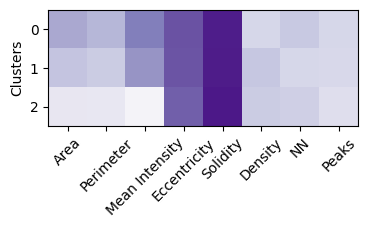

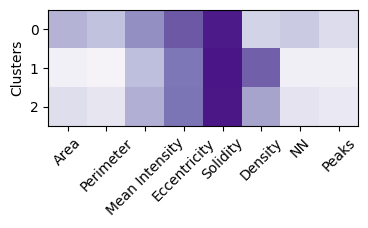

In [83]:
# from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import Ridge

class MaskedMinMaxScaler:
    def __init__(self):

        self.mean = None 
        self.std = None

        self.min = None
        self.max = None

    def fit_transform(self, X, mask):
        self.fit(X, mask)
        return self.transform(X)
    
    def fit(self, X, mask):
        # self.mean = numpy.mean(X, axis=0, keepdims=True)
        # self.std = numpy.std(X, axis=0, keepdims=True)
        self.min = numpy.min(X, axis=0, keepdims=True)
        self.max = numpy.max(X, axis=0, keepdims=True)

        mask = numpy.array(mask)
        # self.mean[:, ~mask] = 0
        # self.std[:, ~mask] = 1

        self.min[:, ~mask] = 0
        self.max[:, ~mask] = 1

    def transform(self, X):
        if self.min is None or self.max is None:
            raise ValueError("Scaler has not been fitted yet")
        X = (X - self.min) / (self.max - self.min)
        return X

all_trajectories = []
for condition, labels in clusters_per_condition.items():
    trajectories = numpy.array(trajectories_per_condition[condition])
    trajectories = trajectories.reshape(-1, trajectories.shape[-1])
    all_trajectories.append(trajectories)
all_trajectories = numpy.concatenate(all_trajectories, axis=0)

scaler = MaskedMinMaxScaler()
scaler.fit(all_trajectories, [f not in ["Eccentricity", "Solidity"] for f in FEATURES])

for condition, labels in clusters_per_condition.items():
    
    trajectories = numpy.array(trajectories_per_condition[condition])
    trajectories = trajectories.reshape(-1, trajectories.shape[-1])
    trajectories = scaler.transform(trajectories)

    deep_trajectories = numpy.array(deep_trajectories_per_condition[condition])
    deep_trajectories = deep_trajectories.reshape(-1, deep_trajectories.shape[-1])

    unique_labels = numpy.unique(labels)
    correlation_matrix = numpy.zeros((len(unique_labels), trajectories.shape[-1]))
    for i, cluster_id in enumerate(unique_labels):
        mask = labels == cluster_id

        d_traj = deep_trajectories[mask]
        t_traj = trajectories[mask]

        for feature_idx in range(t_traj.shape[-1]):
            
            # clf = Ridge(random_state=42)
            # clf.fit(d_traj, t_traj[:, feature_idx])
            # score = clf.score(d_traj, t_traj[:, feature_idx])
            # print(score)
            correlation_matrix[i, feature_idx] = numpy.mean(t_traj[:, feature_idx])

    fig, ax = pyplot.subplots(figsize=(4, 4))
    ax.imshow(correlation_matrix, cmap="Purples", vmin=0, vmax=1)
    ax.set(
        ylabel="Clusters",
    )
    ax.set_xticks(
        numpy.arange(0, trajectories.shape[-1], 1), labels=[FEATURES[i] for i in range(trajectories.shape[-1])],
        rotation=45
    )
    savefig(fig, f"./activity-experiment/figures/deep-features/{condition}_manual-features-per-cluster", save_white=True)
    pyplot.show()
    
    